In [69]:
import os
import sys
sys.path.append('../')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from authenticate_service_account import main
from utils import *


In [70]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


In [71]:
# data = results.to_dataframe()


In [72]:
# data.to_csv('top_10_ods.csv', index=False)


In [73]:
data = pd.read_csv('../raw_data/top_10_ods.csv')


In [74]:
data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
       'ItinLowe

In [75]:
def create_od_column(df, raw_od_columns):
    df['OD'] = df[raw_od_columns[0]] + df[raw_od_columns[1]]

    return df


In [76]:
data_with_od = create_od_column(data, ['OriginCty', 'DestinationCty'])


In [77]:
columns_for_model = ['OD', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'Seg_0_TravelDistanceKm', 'Seg_1_TravelDistanceKm', 'Seg_2_TravelDistanceKm', 'Seg_3_TravelDistanceKm',
                     'ItineraryRedirects', 'ODRedirects',
                     'Seg_0_DurationMin' ,'Seg_1_DurationMin', 'Seg_2_DurationMin', 'Seg_3_DurationMin', 'DurationMin']


In [78]:
model_data = data_with_od[columns_for_model].copy()
model_data


,OD,TravelDistanceKm,Stops,TravelHorizonDays,Seg_0_TravelDistanceKm,Seg_1_TravelDistanceKm,Seg_2_TravelDistanceKm,Seg_3_TravelDistanceKm,ItineraryRedirects,ODRedirects,Seg_0_DurationMin,Seg_1_DurationMin,Seg_2_DurationMin,Seg_3_DurationMin,DurationMin
0,DELBOM,1140,0,180,1140,NaN,NaN,NaN,5,5,135.0,NaN,NaN,NaN,135
1,HKGBKK,1689,0,279,1689,NaN,NaN,NaN,4,5,175.0,NaN,NaN,NaN,175
2,HKGBKK,1689,0,279,1689,NaN,NaN,NaN,1,5,195.0,NaN,NaN,NaN,195
3,HKGTPE,806,0,136,806,NaN,NaN,NaN,4,37,100.0,NaN,NaN,NaN,100
4,HKGTPE,806,0,136,806,NaN,NaN,NaN,3,37,115.0,NaN,NaN,NaN,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28164,TYOBKK,4648,0,138,4648,NaN,NaN,NaN,7,21,430.0,NaN,NaN,NaN,430
28165,TYOBKK,4648,1,138,1257,3668.0,NaN,NaN,1,21,150.0,360.0,NaN,NaN,780
28166,TYOBKK,4648,1,138,1257,3668.0,NaN,NaN,1,21,150.0,335.0,NaN,NaN,645
28167,TYOBKK,4648,1,340,5357,1416.0,NaN,NaN,1,2,430.0,150.0,NaN,NaN,650


In [79]:
data_with_layover = calculate_total_layover_time(model_data)


In [80]:
clean_data = drop_neg_layover_time(data_with_layover)


<Axes: >

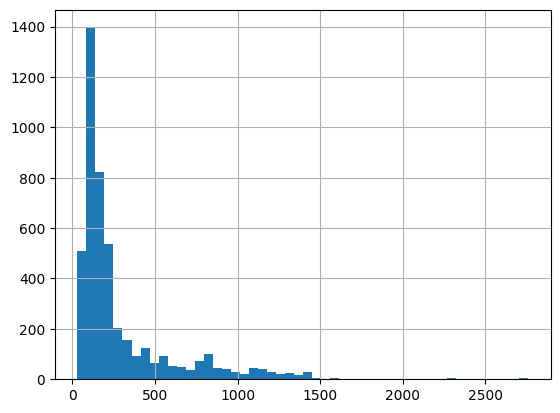

In [81]:

clean_data[clean_data['total_layover_time'] > 0]['total_layover_time'].hist(bins=50)


In [82]:
sorted_data = clean_data[clean_data['total_layover_time'] > 0]['total_layover_time'].sort_values()
cumulative = np.arange(1, len(sorted_data) +1) / len(sorted_data)


Text(0, 0.5, '% share of the data')

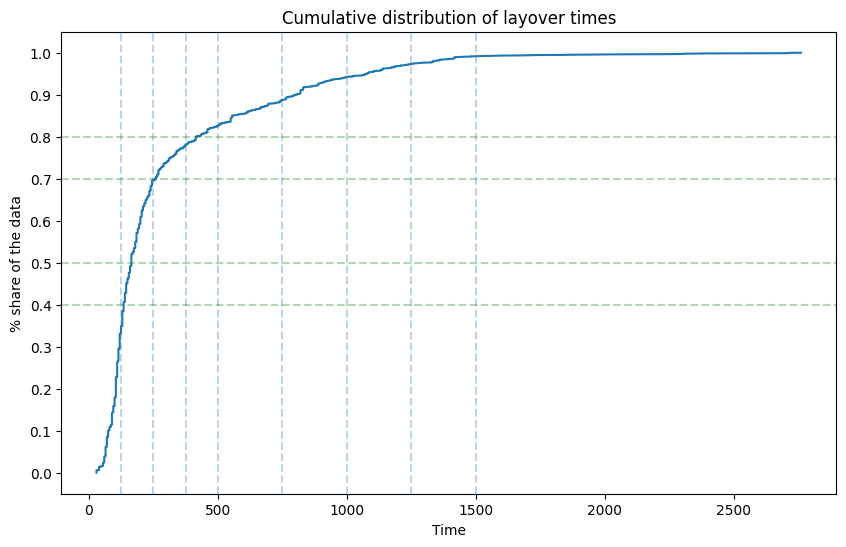

In [83]:
plt.figure(figsize=(10,6))
plt.plot(sorted_data, cumulative)
plt.yticks(np.linspace(0, 1, 11))
x_values = [125, 250, 375, 500, 750, 1000, 1250, 1500]  # Replace x1, x2, x3 with your specific values
for x in x_values:
    plt.axvline(x=x, linestyle='--', alpha=0.3)

y_values = [0.4, 0.5, 0.7, 0.8]
for y in y_values:
    plt.axhline(y=y, color='green', linestyle='--', alpha=0.3)

plt.title("Cumulative distribution of layover times")
plt.xlabel('Time')
plt.ylabel('% share of the data')


# Start from scratch with data 

## Running preprocessor

In [84]:
processed_data = preprocess(data, ['OriginCty', 'DestinationCty'])
processed_data


,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,Price,PricePerPax,ItineraryRedirects,ODRedirects,OD,redirect_ratio,total_travel_time,total_layover_time,total_distance_traveled,extra_travel_distance
0,DEL,DEL,IN,BOM,BOM,IN,180,1140,False,0,...,172.730000,57.580000,5,5,DELBOM,1.000000,135.0,0.0,1140.0,0.0
1,HKG,HKG,CN,BKK,BKK,TH,279,1689,False,0,...,184.716250,92.358750,4,5,HKGBKK,0.800000,175.0,0.0,1689.0,0.0
2,HKG,HKG,CN,BKK,BKK,TH,279,1689,False,0,...,275.780000,137.890000,1,5,HKGBKK,0.200000,195.0,0.0,1689.0,0.0
3,HKG,HKG,CN,TPE,TPE,TW,136,806,False,0,...,121.290000,121.290000,4,37,HKGTPE,0.108108,100.0,0.0,806.0,0.0
4,HKG,HKG,CN,TPE,TPE,TW,136,806,False,0,...,142.770000,106.105000,3,37,HKGTPE,0.081081,115.0,0.0,806.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28164,NRT,TYO,JP,BKK,BKK,TH,138,4648,False,0,...,421.404286,421.404286,7,21,TYOBKK,0.333333,430.0,0.0,4648.0,0.0
28165,NRT,TYO,JP,BKK,BKK,TH,138,4648,False,1,...,375.260000,375.260000,1,21,TYOBKK,0.047619,510.0,270.0,4925.0,277.0
28166,NRT,TYO,JP,BKK,BKK,TH,138,4648,False,1,...,414.570000,414.570000,1,21,TYOBKK,0.047619,485.0,160.0,4925.0,277.0
28167,NRT,TYO,JP,BKK,BKK,TH,340,4648,False,1,...,252.725000,252.725000,1,2,TYOBKK,0.500000,580.0,70.0,6773.0,2125.0


In [85]:
df_grouped = processed_data.groupby(["OriginCty", "OriginApt"]).count()
df_grouped


OriginCtry  DestinationApt  DestinationCty  \
OriginCty OriginApt                                               
DEL       DEL              1540            1540            1540   
HKG       HKG              5971            5971            5971   
LON       LCY                20              20              20   
          LGW              1593            1593            1593   
          LHR              5688            5688            5688   
          LTN               103             103             103   
          SEN                 1               1               1   
          STN               323             323             323   
SEL       GMP               787             787             787   
          ICN              2802            2802            2802   
TLV       TLV              3610            3610            3610   
TPE       TPE              2439            2439            2439   
          TSA                 8               8               8   
TYO       HND               880             880             880   
          NRT              2325            2325            2325   

                     DestinationCtry  TravelHorizonDays  TravelDistanceKm  \
OriginCty OriginApt                                                         
DEL       DEL                   1540               1540              1540   
HKG       HKG                   5971               5971              5971   
LON       LCY                     20                 20                20   
          LGW                   1593               1593              1593   
          LHR                   5688               5688              5688   
          LTN                    103                103               103   
          SEN                      1                  1                 1   
          STN                    323                323               323   
SEL       GMP                    787                787               787   
          ICN                   2802               2802              2802   
TLV       TLV                   3610               3610              3610   
TPE       TPE                   2439               2439              2439   
          TSA                      8                  8                 8   
TYO       HND                    880                880               880   
          NRT                   2325               2325              2325   

                     SelfTransfer  Stops  DurationMin  Seg_0_OriginIATA  ...  \
OriginCty OriginApt                                                      ...   
DEL       DEL                1540   1540         1540              1540  ...   
HKG       HKG                5971   5971         5971              5971  ...   
LON       LCY                  20     20           20                20  ...   
          LGW                1593   1593         1593              1593  ...   
          LHR                5688   5688         5688              5688  ...   
          LTN                 103    103          103               103  ...   
          SEN                   1      1            1                 1  ...   
          STN                 323    323          323               323  ...   
SEL       GMP                 787    787          787               787  ...   
          ICN                2802   2802         2802              2802  ...   
TLV       TLV                3610   3610         3610              3610  ...   
TPE       TPE                2439   2439         2439              2439  ...   
          TSA                   8      8            8                 8  ...   
TYO       HND                 880    880          880               880  ...   
          NRT                2325   2325         2325              2325  ...   

                     Price  PricePerPax  ItineraryRedirects  ODRedirects  \
OriginCty OriginApt                                                        
DEL       DEL         1540         1540                154

## Testing the binary encoder

In [86]:
import category_encoders as ce
# Initialize BinaryEncoder
binary_encoder = ce.BinaryEncoder(cols=["OD"])
# Fit and transform the data
binary_encoded_data = binary_encoder.fit_transform(processed_data)
# Print the result
print("Binary Encoded data:")
print(binary_encoded_data.columns)


Binary Encoded data:
Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRat

In [87]:
random_forest_columns = ['OD_0', 'OD_1', 'OD_2', 'OD_3' , 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'redirect_ratio', 'DurationMin', 'total_travel_time', 'total_layover_time', 'passengers', 'total_distance_traveled', 'extra_travel_distance']


In [88]:
corr_matrix = binary_encoded_data[random_forest_columns].corr()
corr_matrix


,OD_0,OD_1,OD_2,OD_3,TravelDistanceKm,Stops,TravelHorizonDays,redirect_ratio,DurationMin,total_travel_time,total_layover_time,passengers,total_distance_traveled,extra_travel_distance
OD_0,1.000000,-0.570068,-0.130639,-0.189820,0.084495,0.021840,0.069238,0.055208,0.085836,0.092065,0.050514,-0.066847,0.075238,-0.017330
OD_1,-0.570068,1.000000,-0.207074,-0.005166,0.400310,0.190774,-0.052053,-0.066291,0.280569,0.372689,0.089686,0.046608,0.399590,0.167232
OD_2,-0.130639,-0.207074,1.000000,-0.294271,-0.555810,-0.206547,0.012422,0.015879,-0.363695,-0.503887,-0.094417,0.085968,-0.540024,-0.146731
OD_3,-0.189820,-0.005166,-0.294271,1.000000,-0.172640,-0.196460,0.033260,0.047923,-0.193168,-0.179366,-0.142918,0.002900,-0.182836,-0.132844
TravelDistanceKm,0.084495,0.400310,-0.555810,-0.172640,1.000000,0.469824,0.030522,-0.069856,0.765312,0.973140,0.290307,-0.169256,0.986799,0.351855
Stops,0.021840,0.190774,-0.206547,-0.196460,0.469824,1.000000,-0.086353,-0.173529,0.777986,0.613078,0.690506,-0.135599,0.557732,0.709260
TravelHorizonDays,0.069238,-0.052053,0.012422,0.033260,0.030522,-0.086353,1.000000,0.513506,-0.030520,0.016384,-0.069587,-0.142529,0.018227,-0.058000
redirect_ratio,0.055208,-0.066291,0.015879,0.047923,-0.069856,-0.173529,0.513506,1.000000,-0.131849,-0.098793,-0.122393,0.215321,-0.084888,-0.116791
DurationMin,0.085836,0.280569,-0.363695,-0.193168,0.765312,0.777986,-0.030520,-0.131849,1.000000,0.845274,0.827391,-0.164353,0.812082,0.597997
total_travel_time,0.092065,0.372689,-0.503887,-0.179366,0.973140,0.613078,0.016384,-0.098793,0.845274,1.000000,0.399276,-0.179946,0.989327,0.510217


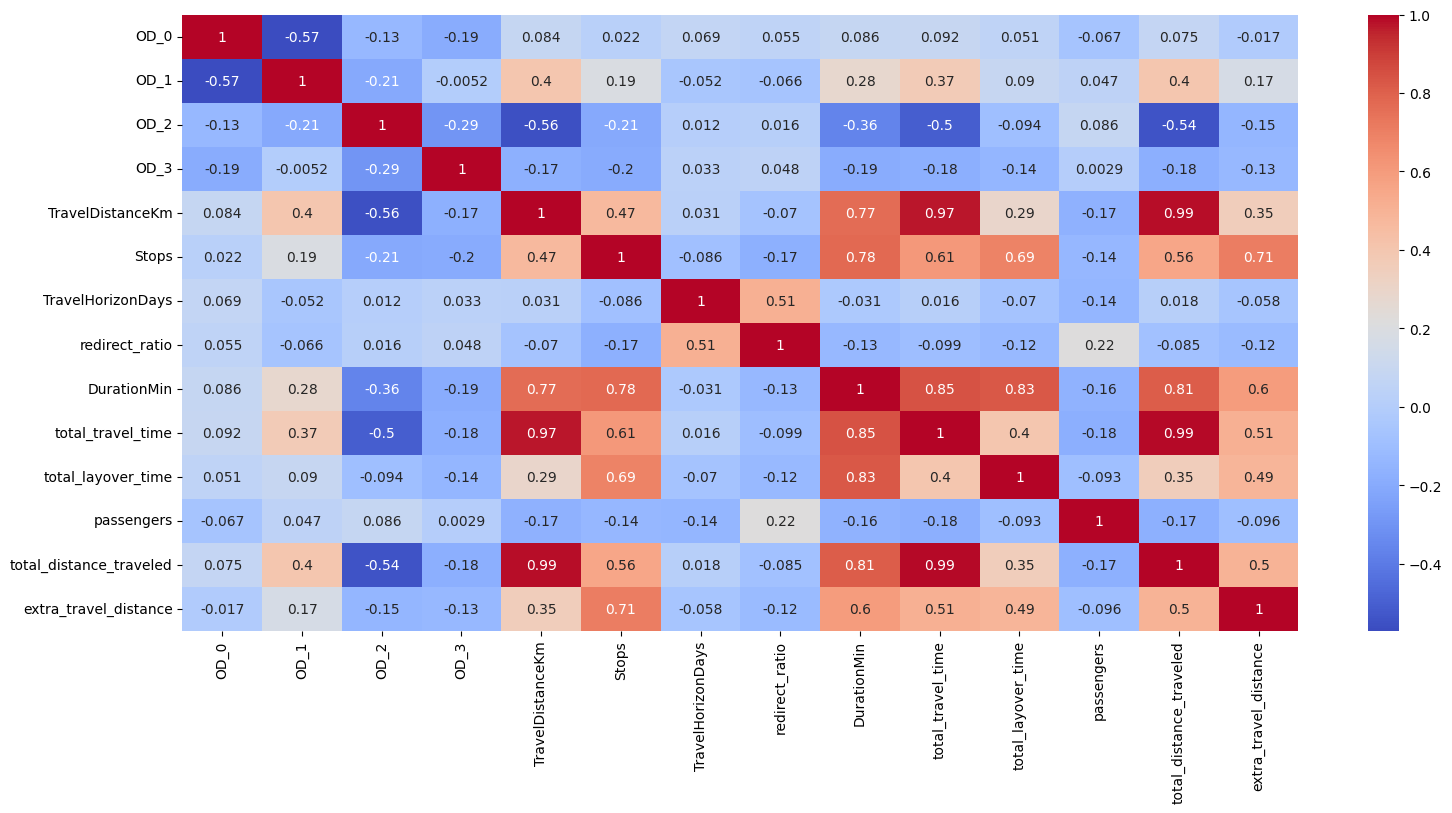

In [89]:
import seaborn as sns
plt.figure(figsize=(18,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [90]:
X_train, X_test, y_train, y_test = create_train_test_split(binary_encoded_data[random_forest_columns], 'redirect_ratio')


In [91]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate


In [92]:
RFreg = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
RFreg.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=0)

In [93]:
print(f"model score on test data: {RFreg.score(X_test, y_test)}")
print(f"model score on train data: {RFreg.score(X_train, y_train)}")


model score on test data: 0.762993204526414
model score on train data: 0.96579264922974


In [94]:
import matplotlib.pyplot as plt
importances = RFreg.feature_importances_


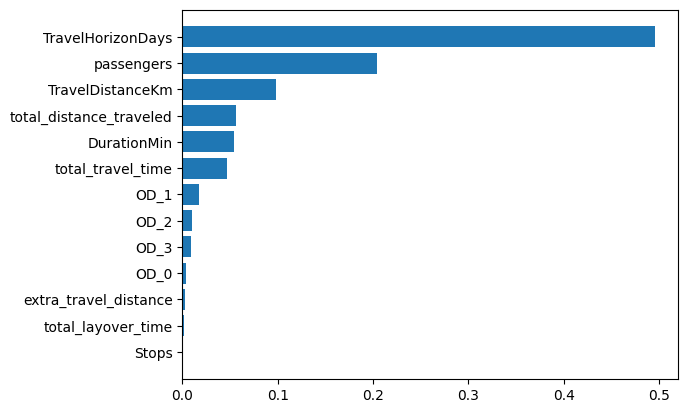

In [95]:
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])


## Replicating results with Antonis train test split

In [96]:
Ant_Train_data = pd.read_csv('../raw_data/train_data_v1.csv')
Ant_Test_data = pd.read_csv('../raw_data/test_data_v1.csv')


In [104]:
new_random_forest_columns = ['TravelDistanceKm', 'TravelHorizonDays',
                     'redirect_ratio', 'DurationMin', 'total_travel_time', 'total_distance_traveled', 'extra_travel_distance']


In [105]:
Ant_Train_data = preprocess(Ant_Train_data, ['OriginCty', 'DestinationCty'])
Ant_Test_data = preprocess(Ant_Test_data, ['OriginCty', 'DestinationCty'])


KeyError: 'ItineraryRedirects'

In [ ]:
Ant_Train_data = Ant_Train_data[new_random_forest_columns]
Ant_Test_data = Ant_Test_data[new_random_forest_columns]


In [ ]:
X_same_train, y_same_train = Ant_Train_data.drop('redirect_ratio', axis=1), Ant_Train_data['redirect_ratio']
X_same_test, y_same_test = Ant_Test_data.drop('redirect_ratio', axis=1), Ant_Test_data['redirect_ratio']


In [ ]:
RFreg_2 = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
RFreg_2.fit(X_same_train, y_same_train)


RandomForestRegressor(n_jobs=-1, random_state=0)

In [ ]:
print(f"model score on test data: {RFreg_2.score(X_same_test, y_same_test)}")
print(f"model score on train data: {RFreg_2.score(X_same_train, y_same_train)}")


model score on test data: 0.452993014273826
model score on train data: 0.8313483534910043


IndexError: index 9 is out of bounds for axis 0 with size 6

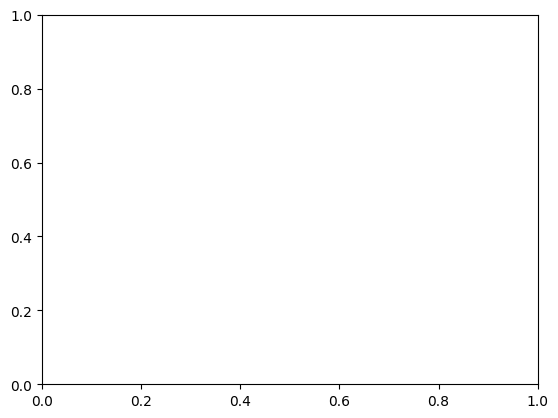

In [ ]:
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_same_train.columns)[indices])
